# QA REGISTRATION
Give a visual result for regisration part to help user check results of each step. The graph includes three dimensions(sagittal slice, coronal slice and axial slice) and uses pink and green to indicate the registered output and reference image.

## Setup Steps
First we have to import all relevant functions used in this qa code. qa_reg uses m2g functions from qa_utils and gen_utils.

In [15]:
import os
import nibabel as nb
import matplotlib.image as mpimg
from m2g.utils.gen_utils import get_braindata, get_filename
from m2g.utils.qa_utils import get_min_max, opaque_colorscale, pad_im
from argparse import ArgumentParser
from scipy import ndimage
from matplotlib.colors import LinearSegmentedColormap
from nilearn.plotting.edge_detect import _edge_map as edge_map
import matplotlib.pyplot as plt
%matplotlib inline

## Saving figures
Save the result returned by function plot_overlays and name the file as "{registered image}2{reference image}".

In [2]:
def reg_mri_pngs(
    mri, atlas, outdir, loc=0, mean=False, minthr=2, maxthr=95, edge=False
):
    """
    A function to create and save registered brain slice figures.
    
    Parameter
    ---------
    mri: nifti file
        the registered brain file generated in each registration step.
    atlas: nifti file
        the reference brain file used in each registration step.
    outdir: str
        directory where output png file is saved. 
    loc: int
        which dimension of the 4d brain data to use 
    mean: bool
        whether to calculate the mean of the 4d brain data 
        If False, the loc=0 dimension of the data (mri_data[:, :, :, loc]) is used 
    minthr: int
         lower percentile threshold  
    maxthr: int
         upper percentile threshold 
    """
    atlas_data = nb.load(atlas).get_data()
    mri_data = nb.load(mri).get_data()
    if mri_data.ndim == 4:  # 4d data, so we need to reduce a dimension
        if mean:
            mr_data = mri_data.mean(axis=3)
        else:
            mr_data = mri_data[:, :, :, loc]
    else:  # dim=3
        mr_data = mri_data

    cmap1 = LinearSegmentedColormap.from_list("mycmap1", ["white", "magenta"])
    cmap2 = LinearSegmentedColormap.from_list("mycmap2", ["white", "green"])

    fig = plot_overlays(atlas_data, mr_data, [cmap1, cmap2], minthr, maxthr, edge)
    # name and save the file
    fig.savefig(outdir + "/" + "{"+get_filename(mri) +"}"+ "2" +"{"+get_filename(atlas)+"}"+ ".png", format="png") 
    
    #plt.close()

## Generating the qa overlay figures
First overlap the registered image and the reference image, then select the appropriate position to cut nine slices {3 slices each from sagittal, axial and coronal} and return the figure foverlay.

In [3]:
def plot_overlays(atlas, b0, cmaps=None, minthr=2, maxthr=95, edge=False):
    """ 
    A function to plot the overlay figures of registered and reference brain slices. 
    
    Parameter 
    --------- 
    atlas: str, nifti image, numpy.ndarray 
        an object to open the data for a registered brain. Can be a string (path to a brain file), 
        nibabel.nifti1.nifti1image, or a numpy.ndarray. 
    b0: str, nifti image, numpy.ndarray 
        an object to open the data for a reference brain. Can be a string (path to a brain file), 
        nibabel.nifti1.nifti1image, or a numpy.ndarray. 
    cmap: Colormap objects based on lookup tables using linear segments. 
    minthr: int 
        lower percentile threshold  
    maxthr: int 
        upper percentile threshold 
    edge: bool 
        whether to use normalized luminance data 
        If None, the respective min and max of the color array is used.  
    
    Returns 
    --------- 
    foverlay: matplotlib.figure.Figure 
    """
    plt.rcParams.update({"axes.labelsize": "x-large", "axes.titlesize": "x-large"})
    foverlay = plt.figure()
    atlas = get_braindata(atlas)
    b0 = get_braindata(b0)
    if atlas.shape != b0.shape:
        raise ValueError("Brains are not the same shape.")
    if cmaps is None:
        cmap1 = LinearSegmentedColormap.from_list("mycmap1", ["white", "magenta"])
        cmap2 = LinearSegmentedColormap.from_list("mycmap2", ["white", "green"])
        cmaps = [cmap1, cmap2]

    if b0.shape == (182, 218, 182):
        x = [78, 90, 100]
        y = [82, 107, 142]
        z = [88, 103, 107]
    else:
        brain_volume = b0.shape
        x = [int(brain_volume[0] * 0.35), int(brain_volume[0] * 0.51), int(brain_volume[0] * 0.65)]
        y = [int(brain_volume[1] * 0.35), int(brain_volume[1] * 0.51), int(brain_volume[1] * 0.65)]
        z = [int(brain_volume[2] * 0.35), int(brain_volume[2] * 0.51), int(brain_volume[2] * 0.65)]
    coords = (x, y, z)
    
    atlas = pad_im(atlas, max(brain_volume[0:3]), 0, False)
    b0 = pad_im(b0, max(brain_volume[0:3]), 0, False)
    x = [int(max(brain_volume[0:3]) * 0.35), int(max(brain_volume[0:3]) * 0.51), int(max(brain_volume[0:3]) * 0.65)]
    y = [int(max(brain_volume[0:3]) * 0.35), int(max(brain_volume[0:3]) * 0.51), int(max(brain_volume[0:3]) * 0.65)]
    z = [int(max(brain_volume[0:3]) * 0.35), int(max(brain_volume[0:3]) * 0.51), int(max(brain_volume[0:3]) * 0.65)]
    coords = (x, y, z)
    
    labs = [
        "Sagittal Slice",
        "Coronal Slice",
        "Axial Slice",
    ]
    var = ["X", "Y", "Z"]
    # create subplot for first slice
    # and customize all labels
    idx = 0
    if edge:
        min_val = 0
        max_val = 1
    else:
        min_val, max_val = get_min_max(b0, minthr, maxthr)

    for i, coord in enumerate(coords):
        for pos in coord:
            idx += 1
            ax = foverlay.add_subplot(3, 3, idx)
            ax.set_title(var[i] + " = " + str(pos))
            if i == 0:
                image = ndimage.rotate(b0[pos, :, :], 90)
                atl = ndimage.rotate(atlas[pos, :, :], 90)
            elif i == 1:
                image = ndimage.rotate(b0[:, pos, :], 90)
                atl = ndimage.rotate(atlas[:, pos, :], 90)
            else:
                image = b0[:, :, pos]
                atl = atlas[:, :, pos]
                
            if idx % 3 == 1:
                ax.set_ylabel(labs[i])
                ax.yaxis.set_ticks([0, image.shape[0] / 2, image.shape[0] - 1])
                ax.xaxis.set_ticks([0, image.shape[1] / 2, image.shape[1] - 1])
            if edge:
                image = edge_map(image).data
                image[image > 0] = max_val
                image[image == 0] = min_val
            #Set the axis invisible
            plt.xticks([])
            plt.yticks([])
            
            #Set the frame invisible
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False)
            
            ax.imshow(atl, interpolation="none", cmap=cmaps[0], alpha=0.9)
            ax.imshow(
                opaque_colorscale(
                    cmaps[1], image, alpha=0.9, vmin=min_val, vmax=max_val
                )
            )
            
            #set the legend
            if idx == 3:
                plt.plot(0,0,"-",c="pink",label='registered')
                plt.plot(0,0,"-",c="green",label='reference')
                plt.legend(loc='best',fontsize=12,bbox_to_anchor=(1.5,1.5))
            
    #Set title for the whole picture
    a,b,c = brain_volume
    title = 'QA For Registration. Brain Volume:'+ str(a) +'*'+ str(b) + '*' + str(c)+'\n'
    foverlay.suptitle(title,fontsize=24)
    foverlay.set_size_inches(12.5, 10.5, forward=True)
    foverlay.tight_layout()
    return foverlay

## Input and Graphs
Change location of mri, atlas and output_dir after running m2g on desired dataset to your output folder

### Anatomical  Registration 
### Parameters:
mri: str
    
    the registered output of the intermediate steps of the registration.

atlas: str
    
    the reference image used in Registration step.

output_dir: str
    
    the str where you save the output png file.

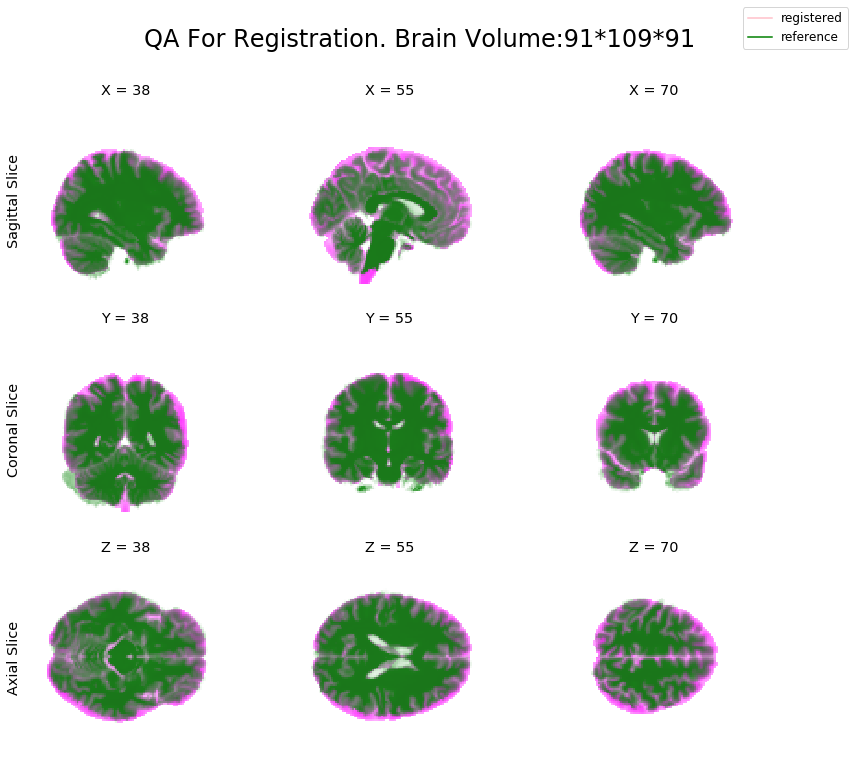

In [4]:
mri = r"/Users/xueminzhu/Desktop/test/t1w_aligned_mni.nii.gz"
atlas = r"/Users/xueminzhu/Desktop/test/MNI152_T1_2mm_brain.nii.gz"
output_dir = r"/Users/xueminzhu/Desktop/test"
reg_mri_pngs(mri, atlas,output_dir)

This is a good example of well-registed images where pink and green are used to represent the registered output and reference image. The registration step of this image is first using function flirt and then fnirt in FSL.

### Atlas Registration
### Parameters:
mri: str
    
    the registered output of the final step of the registration.

atlas: str

    the reference image used in this registration step.

output_dir: str

    the str where you save the output png file.

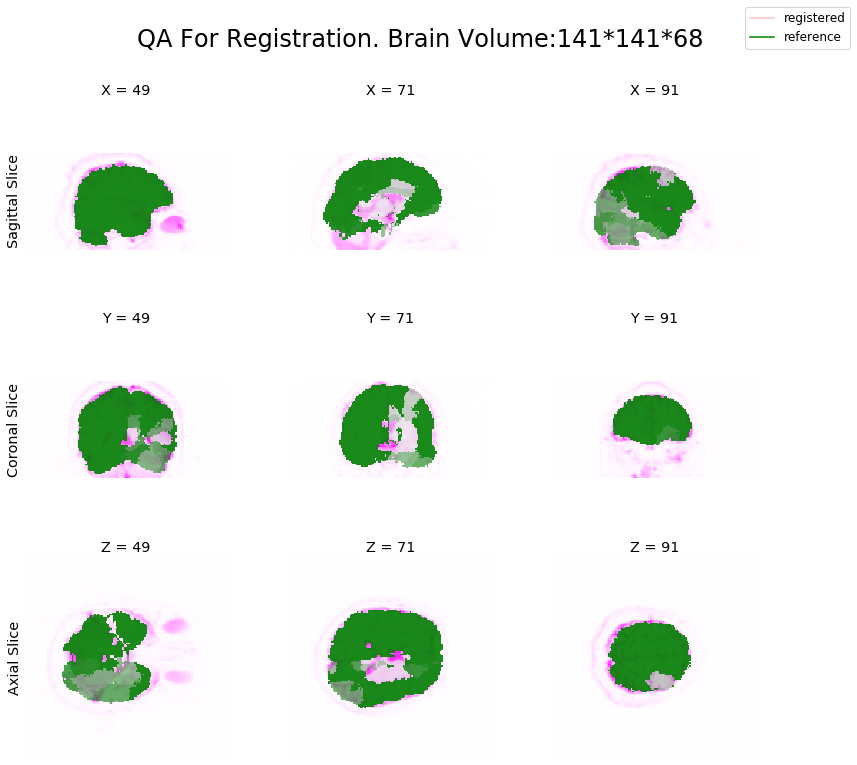

In [5]:
mri = r"/Users/xueminzhu/Desktop/test/desikan_space-MNI152NLin6_res-2x2x2_reor_RAS_nores_aligned_atlas.nii.gz"
atlas = r"/Users/xueminzhu/Desktop/test/nodif_B0.nii.gz"
output_dir = r"/Users/xueminzhu/Desktop/test"
reg_mri_pngs(mri, atlas,output_dir)

This is a final image of the registration step where pink and green are used to represent registered output and reference image. 

A bad output may be missing some slices of the brain or too small, which may be due to the small volume of the picture. The following figure is an example.

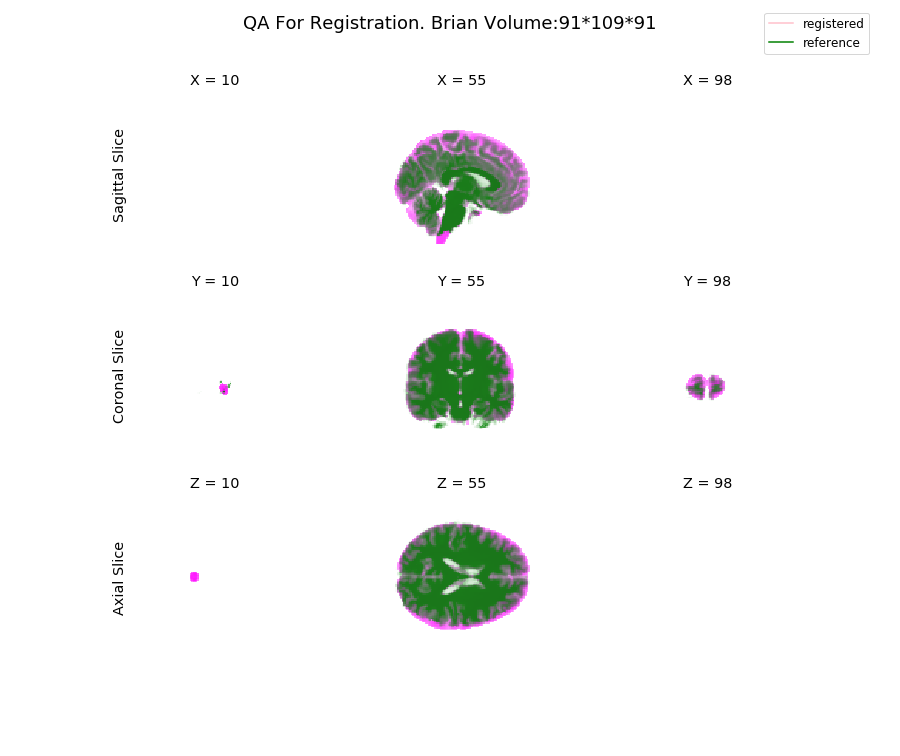

In [24]:
bad_example = r"/Users/xueminzhu/Desktop/test/example.png"
display(Image.open(bad_example))